# Análisis de sentimiento con Regresión Logística 


En este post vamos a realizar un ejemplo simple de cómo dotar de explicabilidad e interpretabilidad a un modelo de análisis de sentimiento de regresión logística lineal usando la librería shap. 

De acuerdo con la información facilitada en el repositorio de la librería, con un modelo lineal el valor SHAP para la característica i para la predicción $f(x)$ (asumiendo que las características son independientes) es solo $ \phi_i = \beta_i \cdot (x_i - E [x_i]) $. Dado que estamos explicando un modelo de regresión logística, las unidades de los valores SHAP estarán en el espacio log-odds.

No nos vamos a complicar para realizar esta prueba de usabilidad; el conjunto de datos que utilizamos es el conjunto de datos clásico de IMDB de [este documento](http://www.aclweb.org/anthology/P11-1015). 


Para empezar a usar la librería, dentro de nuestro entorno virtual de Python simplemente hay que ejecutar el siguiente comando en un terminal:

In [2]:
!pip install shap
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 10.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [1]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

import shap

shap.initjs()

/home/cx02092/miniconda3/envs/df_ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sklearn.__version__

'1.0.2'

## Cargamos el IMDB dataset

In [7]:
corpus, y = shap.datasets.imdb()

In [9]:
corpus[3]

'Sorry everyone,,, I know this is supposed to be an "art" film,, but wow, they should have handed out guns at the screening so people could blow their brains out and not watch. Although the scene design and photographic direction was excellent, this story is too painful to watch. The absence of a sound track was brutal. The loooonnnnng shots were too long. How long can you watch two people just sitting there and talking? Especially when the dialogue is two people complaining. I really had a hard time just getting through this film. The performances were excellent, but how much of that dark, sombre, uninspired, stuff can you take? The only thing i liked was Maureen Stapleton and her red dress and dancing scene. Otherwise this was a ripoff of Bergman. And i\'m no fan f his either. I think anyone who says they enjoyed 1 1/2 hours of this is,, well, lying.\n'

In [10]:
y[3]

False

In [11]:
print('Posibles etiquetas para el dataset: ', np.unique(y, return_counts=True))

Posibles etiquetas para el dataset:  (array([False,  True]), array([12500, 12500]))


In [12]:
from gensim.parsing.preprocessing import remove_stopwords

In [13]:
corpus[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n"

El siguiente paso que debemos realizar es el de eliminar las stopword, las cuales no añaden información adicional al sentimiento de cada reseña.

In [19]:
corpus_cleaned = list()

for review in corpus:
  corpus_cleaned.append(remove_stopwords(review).replace('br ', ''))

In [27]:
corpus_cleaned[0]

"Story man unnatural feelings pig. Starts opening scene terrific example absurd comedy. A formal orchestra audience turned insane, violent mob crazy chantings it's singers. Unfortunately stays absurd W"

In [21]:
corpus_cleaned = [item[:200] for item in corpus_cleaned]

In [18]:
corpus_cleaned[0]

"Story man unnatural feelings pig. Starts opening scene terrific example absurd comedy. A formal orchestra audience turned insane, violent mob crazy chantings it's singers. Unfortunately stays absurd W"

In [22]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus_cleaned, 
                                                              y, 
                                                              test_size=0.2, 
                                                              random_state=42,
                                                              stratify=y)



In [26]:
corpus_test.__len__()

5000

In [28]:
vectorizer = TfidfVectorizer(min_df=10)
#vectorizer = CountVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train).toarray() # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(corpus_test).toarray()

In [29]:
print(X_train.shape)
print(X_test.shape)

(20000, 6391)
(5000, 6391)


In [32]:
X_train[1]

array([0., 0., 0., ..., 0., 0., 0.])

## Entrenar un algoritmo de Regresión Logística

In [33]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [38]:
model.predict([X_test[30]])

array([False])

In [54]:
model.score(X_test, y_test)

0.771

In [39]:
corpus_test[30]

'Why film made? Even keeping mind generous tax concessions Australian film investors given, reasonable explanation film given go-ahead. For goodness sakes, actors cast film Aussie b-grade celebs (not a'

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.78      0.75      0.77      2500
        True       0.76      0.79      0.78      2500

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



In [41]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

       False       0.87      0.84      0.85     10000
        True       0.84      0.88      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



## Explicación del modelo lineal

In [42]:
explainer = shap.Explainer(model, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

### Resumen de la contribución de todas las características

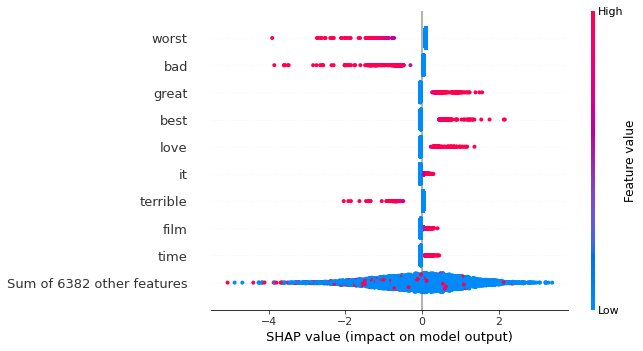

In [43]:
shap.plots.beeswarm(shap_values)

### Explicar la predicción del sentimiento de la primera reseña

Puede observarse que valores más altos significan más probabilidades de ser negativo, por lo que en los gráficos debajo de las características pintadas con color rojo en realidad están ayudando a aumentar la posibilidad de una revisión positiva, mientras que las características negativas reducen la posibilidad. Es interesante ver cómo lo que no está presente en el texto (como bad = 0 a continuación) es a menudo tan importante como todo lo demás que está en el texto. Los valores de las características, en este caso, son valores TF-IDF.


In [44]:
shap.initjs()

ind = 0
shap.plots.force(shap_values[ind])

In [45]:
print("Reseña Positiva" if y_test[ind] else "Reseña Negativa")
print(corpus_test[ind])

Reseña Positiva
Chloe mysteriously saved Dr. Caselli, corrupt doctor responsible transferring patients abilities Belle Reve Project 33.1, fraction second later Clark arrives. He finds Bart Allan returned Smallville m


### Explicar la predicción del sentimiento de la segunda reseña

In [52]:
shap.initjs()

ind = 300
shap.plots.force(shap_values[ind])

In [53]:
print(" Reseña Positiva" if y_test[ind] else "Reseña Negativa")
print(corpus_test[ind])

 Reseña Positiva
Watching movie brought great childhood memories . I'm 34 now, seen I 12-14. I forgotten movie, I watched recently, scenes literally brought tear eye! That little robot "Jinx"(friends ever!). It like r


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler

In [57]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(min_df=10)),
    ('scaler', MaxAbsScaler()),
    ('classifier', LogisticRegression())
])

In [ ]:
pipeline

Pipeline(steps=[('vectorizer', CountVectorizer(min_df=10)),
                ('scaler', MaxAbsScaler()),
                ('classifier', LogisticRegression())])

In [58]:
pipeline.fit(corpus_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(min_df=10)),
                ('scaler', MaxAbsScaler()),
                ('classifier', LogisticRegression())])

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipeline.predict(corpus_test)))

              precision    recall  f1-score   support

       False       0.77      0.76      0.76      2500
        True       0.76      0.77      0.76      2500

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000



In [60]:
pipeline.predict(corpus_test)

array([False,  True, False, ...,  True,  True, False])